In [ ]:
from utils import * 
import os 
from src.ggkbase import * 
import glob
import matplotlib as mpl 
from src.files import BLASTFileJSON, FASTAFile, InterProScanFileTSV, GenBankFile, fasta_get_genome_size
import subprocess
import networkx as nx
from matplotlib.colors import LinearSegmentedColormap, to_hex
from src.metat import metat_load 

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
cmap_blues = LinearSegmentedColormap.from_list('blues', ['lightblue', 'steelblue'])
cmap_grays = LinearSegmentedColormap.from_list('grays', ['lightgray', 'gray'])

def cmap_sample(cmap, n):
    return [to_hex(color) for color in cmap(np.linspace(0, 1, n))]

In [52]:
contig_size_df = list()
for target_name in id_to_ggkbase_name_map.keys():
    use_contig_index = ('mp' in target_name)
    for contig_id, contig_size in fasta_get_contig_sizes(f'../data/data/{target_name}.fn', use_contig_index=use_contig_index).items():
        contig_size_df.append({'target_name':target_name, 'contig_id':contig_id, 'contig_size':contig_size})
contig_size_df = pd.DataFrame(contig_size_df)


In [53]:
contig_size_df

,target_name,contig_id,contig_size
0,mp_4,1,92103
1,mp_4,2,89562
2,mp_4,3,87812
3,mp_4,4,81121
4,mp_4,5,80480
...,...,...,...
1232,black_borg,SR-VP_05_06_2024_coassembly_scaffold_129,521903
1233,black_borg,SR-VP_05_06_2024_coassembly_scaffold_262,376860
1234,black_borg,SR-VP_05_06_2024_coassembly_scaffold_2575,115649
1235,black_borg,SR-VP_05_06_2024_coassembly_scaffold_851197,2197


In [54]:
coverm_df = coverm_load('../data/coverm', contig_size_df=contig_size_df)
coverm_df['bioreactor'] = coverm_df.sample_id.str.match(r'ck_.*|n_.*')
coverm_df = coverm_df[coverm_df.bioreactor].copy()

def remove_low_abundance_targets(coverm_df, min_rpkm:float=1, min_n_samples:int=1):
    include_target_names = coverm_df.groupby('target_name').apply(lambda df : (df.rpkm > min_rpkm).sum() > min_n_samples, include_groups=False)
    include_target_names = include_target_names[include_target_names].index 
    n_target_names = coverm_df.target_name.nunique()
    print(f'remove_low_abundance_targets: Retaining {len(include_target_names)} out of {n_target_names} targets after filtering for abundance.')
    return coverm_df[coverm_df.target_name.isin(include_target_names)].copy()


In [55]:
def plot_abundance(figure_df:pd.DataFrame, title=r'$\it{Methanoperedens}$ abundance', min_rpkm=1e-2, legend:bool=True, ax=None):

    figure_df = figure_df.sort_values(['sample_id', 'target_name'], ascending=False)
    # figure_df = figure_df.copy()
    figure_df['year'] = [re.search(r'202\d', sample_id).group(0) for sample_id in figure_df.sample_id]
    figure_df = remove_low_abundance_targets(figure_df, min_rpkm=min_rpkm).copy()
    
    sample_ids = figure_df.sample_id.unique()
    n_samples = figure_df.sample_id.nunique()

    target_names = sorted(figure_df.target_name.unique())
    palettes = dict()
    palettes['2024'] = dict(zip(target_names, cmap_sample(cmap_grays, len(target_names))))
    palettes['2025'] = dict(zip(target_names, cmap_sample(cmap_blues, len(target_names))))
    # print(palettes)

    bottom = np.zeros(n_samples)
    for target_name, df in figure_df.groupby('target_name'):
        colors = [palettes[year].get(target_name, 'red') for year in df.year]
        heights = df.set_index('sample_id').rpkm.to_dict() # Make this robust to when some samples aren't present. 
        heights = np.array([heights.get(sample_id, 0) for sample_id in sample_ids])
        ax.bar(x=np.arange(n_samples), height=heights, bottom=bottom, label=target_name, edgecolor='black', lw=0.7, color=colors)
        bottom += heights
    ax.set_title(title)
    ax.set_ylabel('RPKM')
    ax.set_xticks(np.arange(n_samples), labels=[sample_id.replace('_metat', '') for sample_id in sample_ids], rotation=90)

    if legend:
        handles = [Patch(edgecolor='black', linewidth=0.7, facecolor=palettes['2025'][target_name]) for target_name in target_names]
        ax.legend(handles, target_names)


remove_low_abundance_targets: Retaining 5 out of 5 targets after filtering for abundance.
remove_low_abundance_targets: Retaining 4 out of 25 targets after filtering for abundance.


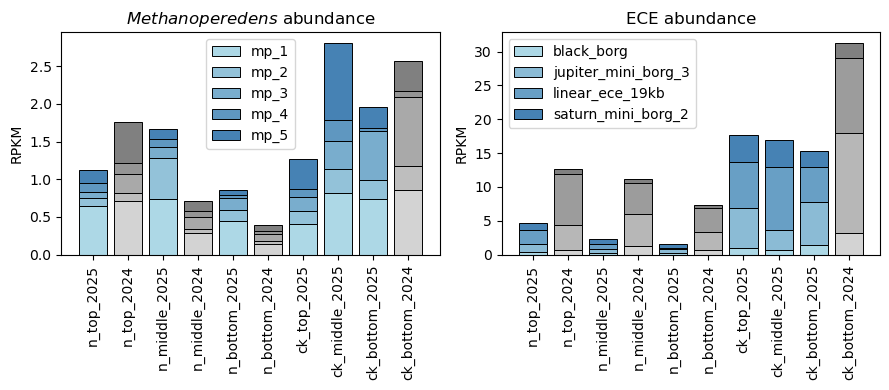

In [56]:
fig, (ax_a, ax_b) = plt.subplots(figsize=(9, 4), ncols=2)

plot_abundance(coverm_df[coverm_df.target_name.str.startswith('mp_')].copy(), ax=ax_a, title=r'$\it{Methanoperedens}$ abundance', min_rpkm=1e-2)
plot_abundance(coverm_df[~coverm_df.target_name.str.startswith('mp_')].copy(), ax=ax_b, title='ECE abundance', min_rpkm=1)

fig.tight_layout()
plt.show()

In [57]:
interproscan_df = load_interproscan().rename(columns={'id':'gene_id'}).drop(columns=['length'])
interproscan_df = interproscan_df[interproscan_df.target_name.str.startswith('mp_')]

def is_ribosome_protein(df):
    # ribosome_proteins = ['L2,', 'L3,', 'L4,', 'L5,', 'L6,', 'L14,', 'L16,', 'L18,', 'L22,', 'L24,', 'S3,', 'S8,', 'S10,', 'S17', 'S19', 'L31']
    mask = (df.signature_description.str.contains('ribosomal', case=False) & df.signature_description.str.contains('L|S|P', regex=True))
    # https://pmc.ncbi.nlm.nih.gov/articles/PMC9399092/
    exclude_signatures = ['methyltransferase', 'METHYLTRANSFERASE', 'METHYLTHIOTRANSFERASE', 'PROCESSING', 'acetyltransferase', 'MODIFICATION', '40S']
    exclude_signatures += ['Ribosomal protein S5 domain 2-like', 'Brix'] # https://www.ebi.ac.uk/interpro/entry/InterPro/IPR020568/
    mask = mask & (~df.signature_description.str.contains('|'.join(exclude_signatures), regex=True))
    return mask

get_ribosome_protein = lambda description : re.search(r'(S|L|P)\d+', description).group(0) if (re.search(r'(S|L|P)\d+', description)) is not None else 'none'
ribosome_proteins_df = interproscan_df[is_ribosome_protein(interproscan_df)].copy()
ribosome_proteins_df['protein'] = [get_ribosome_protein(description) for description in ribosome_proteins_df.signature_description]
ribosome_proteins_df = ribosome_proteins_df.sort_values('e_value').drop_duplicates(['target_name', 'protein'])

for target_name, df in ribosome_proteins_df.groupby('target_name'):
    print(f'Num. ribosomal proteins found in {target_name}:', len(df))

# ribosome_proteins_df.to_csv('mp_ribosome_proteins.csv')

Num. ribosomal proteins found in mp_1: 52
Num. ribosomal proteins found in mp_2: 2
Num. ribosomal proteins found in mp_3: 49
Num. ribosomal proteins found in mp_4: 54
Num. ribosomal proteins found in mp_5: 51


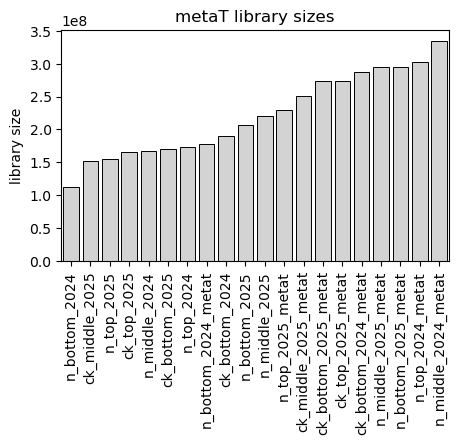

In [58]:
bbduk_df = bbduk_load('../data/bbduk')

fig, ax = plt.subplots(figsize=(5, 3))
figure_df =  bbduk_df[bbduk_df.index.str.contains('ck_|n_')].copy() # Bioreactor samples only.
figure_df = figure_df.reset_index(drop=False) 
figure_df = figure_df.sort_values('library_size')
sns.barplot(figure_df, y='library_size', x='sample_id', color='lightgray', edgecolor='black', lw=0.7) #, hue='library_size', palette='Grays', legend=False)
ax.set_xlabel('')
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)
ax.set_ylabel('library size')
ax.set_title('metaT library sizes')
plt.show()
# for row in bbduk_df[bbduk_df.index.str.contains('ck_|n_')].itertuples():
#     print(row.Index, row.library_size)

# Library sizes range from around 150,000,000 to 350,000,000. Probably want to be more lenient than not, so select a CPM
# which could correspond to a count of ~5 for 1e8, or (5 / (1e8 / 1e6))

In [ ]:
metat_df = metat_load()

,gene_id,contig_id,start,end,strand,length,read_count,sample_id,target_name,coverage,library_size,location,reactor,year
0,mp_1.1_1,mp_1.1,3,91,+,89,0,n_top_2025_metat,mp_1,0.000000,229018512,top,n,2025
1,mp_1.1_2,mp_1.1,193,698,-,506,22,n_top_2025_metat,mp_1,6.521739,229018512,top,n,2025
2,mp_1.1_3,mp_1.1,1040,2322,-,1283,0,n_top_2025_metat,mp_1,0.000000,229018512,top,n,2025
3,mp_1.1_4,mp_1.1,2402,3057,-,656,0,n_top_2025_metat,mp_1,0.000000,229018512,top,n,2025
4,mp_1.1_5,mp_1.1,3092,3630,-,539,0,n_top_2025_metat,mp_1,0.000000,229018512,top,n,2025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194452,28_3,SR-VP_05_06_2024_coassembly_scaffold_1960231,1198,1265,-,68,0,ck_middle_2025_metat,jupiter_mini_borg_2,0.000000,250326764,middle,ck,2025
194453,29_1,SR-VP_05_06_2024_coassembly_scaffold_2084789,2,1218,-,1217,0,ck_middle_2025_metat,jupiter_mini_borg_2,0.000000,250326764,middle,ck,2025
194454,30_1,SR-VP_05_06_2024_coassembly_scaffold_2142760,4,98,+,95,0,ck_middle_2025_metat,jupiter_mini_borg_2,0.000000,250326764,middle,ck,2025
194455,30_2,SR-VP_05_06_2024_coassembly_scaffold_2142760,281,1098,+,818,0,ck_middle_2025_metat,jupiter_mini_borg_2,0.000000,250326764,middle,ck,2025


remove_low_abundance_targets: Retaining 5 out of 5 targets after filtering for abundance.
remove_low_abundance_targets: Retaining 4 out of 23 targets after filtering for abundance.


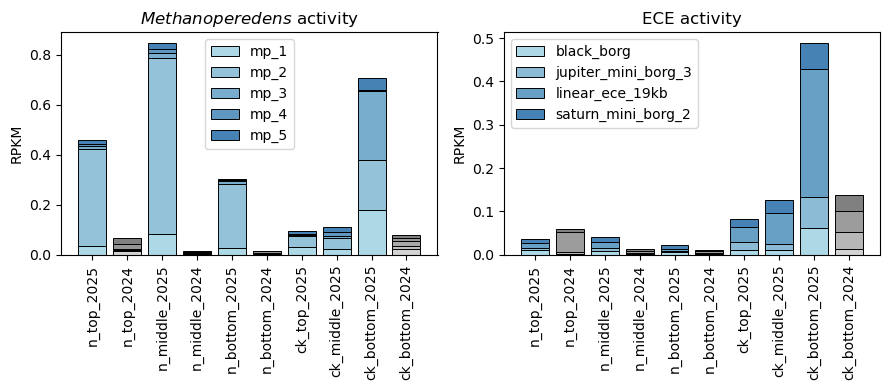

In [73]:
fig, (ax_a, ax_b) = plt.subplots(figsize=(9, 4), ncols=2)

figure_df = metat_df.groupby(['target_name', 'sample_id']).agg({'read_count':'sum', 'length':'sum', 'library_size':'first'}).reset_index()
figure_df['rpkm'] = figure_df.read_count / (figure_df.length / 1e3) / (figure_df.library_size / 1e6)

plot_abundance(figure_df[is_mp(figure_df)], ax=ax_a, title=r'$\it{Methanoperedens}$ activity', min_rpkm=1e-2)
plot_abundance(figure_df[~is_mp(figure_df)], ax=ax_b, title='ECE activity', min_rpkm=1e-2)

fig.tight_layout()
plt.show()

In [71]:
figure_df

,target_name,sample_id,read_count,length
0,amethyst_borg,n_middle_2024_metat,0,35471
1,amethyst_borg,n_middle_2025_metat,0,35471
2,black_borg,ck_bottom_2024_metat,3415,846614
3,black_borg,ck_bottom_2025_metat,14350,846614
4,black_borg,ck_middle_2025_metat,2214,846614
...,...,...,...,...
208,vermilion_borg,n_bottom_2025_metat,196,690443
209,vermilion_borg,n_middle_2024_metat,19,690443
210,vermilion_borg,n_middle_2025_metat,71,690443
211,vermilion_borg,n_top_2024_metat,7,690443


In [62]:
# Check to make sure all the proteins agree with what's in the FASTA file I've been working with.
def check(df, target_name:str=None):
    df_ = FASTAFile.from_file(f'../data/data/{target_name}.fa').to_df(parse_description=False)
    assert len(df_) == len(df), 'check'
    assert np.all(df.gene_id.values == df_.index.values), 'check'

fasta_df = list()
for target_name in ['mp_1', 'mp_2', 'mp_3', 'mp_4', 'mp_5']:
    path = os.path.join('../data/ggkbase/genes', f'{id_to_ggkbase_name_map[target_name]}.genes.fna')
    df = FASTAFile().from_file(path).to_df(parse_description=False)
    df = df[~df.index.str.contains('trna')] # Get rid of the tRNA genes.
    df['contig_id'] = [re.search(r'.*_scaffold_\d+', id_).group(0) for id_ in df.index]
    contig_id_map = {contig_id:i + 1 for i, contig_id in enumerate(df.contig_id.unique())}
    df['gene_id'] = [re.search(r'.*_scaffold_\d+_(\d+)', id_).group(1) for id_ in df.index]
    df['gene_id'] = [f'{contig_id_map[row.contig_id]}_{row.gene_id}' for row in df.itertuples()]
    df['target_name'] = target_name
    df.index = [f'{target_name}.{gene_id}' for gene_id in df.gene_id]
    check(df, target_name=target_name)
    fasta_df.append(df)

fasta_df = pd.concat(fasta_df)
FASTAFile.from_df(fasta_df).write('../data/mp.genes.fn')
    

In [63]:
# Want to check on the protein-level similarity in the Methanoperedens to check on double-mapping reads. 
# Already filtering for consistent up- or down- regulation across all three comparisons. 

# Double-mapping won't matter for the differential expression analyis, but would matter for absolute abundance. 

cluster_df = pd.read_csv('../data/mmseqs/mp.genes_cluster.tsv', names=['rep_gene_id', 'gene_id'], sep='\t') # Clustered at 99% identity. 
cluster_id_map = {rep_gene_id:i for i, rep_gene_id in enumerate(cluster_df.rep_gene_id.unique())}
cluster_df['cluster_id'] = cluster_df.rep_gene_id.map(cluster_id_map).astype(int)
cluster_df['target_name'] = [gene_id.split('.')[0] for gene_id in cluster_df.gene_id]
cluster_df['gene_id'] = [gene_id.split('.')[1] for gene_id in cluster_df.gene_id]
print('Num. genes:', len(cluster_df))
print('Num. clusters:', cluster_df.cluster_id.nunique())

cluster_df['n_targets_in_cluster'] = cluster_df.cluster_id.map(cluster_df.groupby('cluster_id').target_name.nunique())
print('Num. identical genes:', (cluster_df.n_targets_in_cluster > 1).sum())

# What is most important for any skewing in the RPKM is the fraction of each genome which is potentially double-counted. 
print()
for target_name, df in cluster_df.groupby('target_name'):
    print(f'Percentage of coding region {target_name} identical:', f'{(df.n_targets_in_cluster > 1).mean() * 100:.2f}%')


Num. genes: 12813
Num. clusters: 9373
Num. identical genes: 5448

Percentage of coding region mp_1 identical: 59.48%
Percentage of coding region mp_2 identical: 20.39%
Percentage of coding region mp_3 identical: 27.59%
Percentage of coding region mp_4 identical: 29.29%
Percentage of coding region mp_5 identical: 63.45%


In [64]:
# Worth taking a look at the actual read data. 

sample_id = 'ck_bottom_2024_metat'
target_names = [f'mp_{i + 1}' for i in range(5)]
# target_names = ['mp_1', 'mp_5']

mapped_reads_df = pd.concat([pd.read_csv(f'../data/metat/{target_name}/{sample_id}.csv').assign(target_name=target_name) for target_name in target_names])
mapped_read_counts = mapped_reads_df.groupby('read_id').apply(lambda df : df.target_name.nunique() > 1, include_groups=False)
mapped_read_counts = mapped_read_counts[mapped_read_counts]

n_mapped_reads = mapped_reads_df.read_id.nunique()
print('Num. mapped reads:', n_mapped_reads)
print('Num. mapped reads double-counted:', len(mapped_read_counts), f'({100 * len(mapped_read_counts) / n_mapped_reads:.2f}%)')


Num. mapped reads: 135841
Num. mapped reads double-counted: 22433 (16.51%)


In [65]:

# I am generally worried about double-counting reads, so going to try mapping everything at once. This will not count ambiguous reads, which could be a problem, 
# but will ensure that the best mapping choices are made across strains. 

fasta_nt_path = '../data/data/mp.fn'
fasta_aa_path = '../data/data/mp.fa'
gff_path = '../data/data/mp.gff'

target_names = [f'mp_{i + 1}' for i in range(5)]

for target_name in target_names:
    genbank_file = GenBankFile.from_file(f'../data/data/{target_name}.gbk')
    genbank_file.df['contig_id'] = [f'{target_name}.{contig_index}' for contig_index in genbank_file.df.contig_index]
    genbank_file.df['gene_id'] = [f'{target_name}.{gene_id}' for gene_id in genbank_file.df.gene_id]
    genbank_file.to_fasta(fasta_aa_path, mode='w' if (target_name == 'mp_1') else 'a')
    genbank_file.to_gff(gff_path, mode='w' if (target_name == 'mp_1') else 'a')

    fasta_nt_file = FASTAFile.from_file(f'../data/data/{target_name}.fn')
    fasta_nt_file.ids = np.array([f'{target_name}.{i + 1}' for i in range(len(fasta_nt_file.ids))])
    fasta_nt_file.write(fasta_nt_path, mode='w' if (target_name == 'mp_1') else 'a')



In [66]:
genbank_df.to_df()['product'][genbank_df.to_df()['product'].str.contains('Tax=')]

NameError: name 'genbank_df' is not defined

In [ ]:
# How much can changes in overall abundance explain changes in activity?
mapped_read_counts
mapped_reads_df[mapped_reads_df.read_id.isin(mapped_read_counts.index)]


,read_id,contig_id,start,target_name
0,VH00771:209:AACWGGFHV:1:2106:63487:50033,SR-VP_05_06_2024_ck_bottom_scaffold_83,514,mp_1
1,VH00771:209:AACWGGFHV:1:1206:56708:4408,SR-VP_05_06_2024_ck_bottom_scaffold_83,705,mp_1
2,VH00771:209:AACWGGFHV:1:2510:39780:39204,SR-VP_05_06_2024_ck_bottom_scaffold_83,705,mp_1
3,VH00771:209:AACWGGFHV:1:2510:39799:39185,SR-VP_05_06_2024_ck_bottom_scaffold_83,705,mp_1
4,VH00771:209:AACWGGFHV:1:1206:56708:4408,SR-VP_05_06_2024_ck_bottom_scaffold_83,724,mp_1
...,...,...,...,...
39543,VH00771:209:AACWGGFHV:2:2113:56064:10996,SR-VP_05_06_2024_N_top_scaffold_171803,2853,mp_5
39544,VH00771:209:AACWGGFHV:2:2406:21185:33449,SR-VP_05_06_2024_N_top_scaffold_171803,2853,mp_5
39545,VH00771:209:AACWGGFHV:2:2406:28097:36649,SR-VP_05_06_2024_N_top_scaffold_171803,2853,mp_5
39546,VH00771:209:AACWGGFHV:2:1606:75663:35816,SR-VP_05_06_2024_N_top_scaffold_171803,2914,mp_5


In [ ]:
cluster_df

,rep_gene_id,gene_id,cluster_id,target_name,n_targets_in_cluster
0,mp_1.4_19,4_19,0,mp_1,2
1,mp_1.4_19,9_50,0,mp_5,2
2,mp_1.4_20,4_20,1,mp_1,4
3,mp_1.4_20,31_13,1,mp_3,4
4,mp_1.4_20,37_32,1,mp_4,4
...,...,...,...,...,...
12808,mp_1.46_14,46_14,9370,mp_1,1
12809,mp_1.46_17,46_17,9371,mp_1,1
12810,mp_1.47_3,47_3,9372,mp_1,3
12811,mp_1.47_3,2_56,9372,mp_4,3
